This runs and displays benchmark performance for various tools

In [105]:
%cd twitteranalysis
import environment 

import pandas as pd
#Plotting 
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")

# Timing etc tools (e.g., @timefn)
from OptimizationTools import *


(bookmark:twitteranalysis) -> /Users/adam/Dropbox/PainNarrativesLab/TwitterDataAnalysis
/Users/adam/Dropbox/PainNarrativesLab/TwitterDataAnalysis


# Runtimes of main()

In [106]:
# Load the times recorded from running main
runtime = pd.read_csv(environment.RUN_TIME_LOG, header=None, names=['start', 'stop', 'numProcessed', 'note'])

runtime.start = pd.to_datetime(runtime.start)
runtime.stop = pd.to_datetime(runtime.stop)

def c(row):
    delta = row.stop - row.start
    # convert to seconds
    return delta / np.timedelta64(1, 's')

runtime['duration'] = runtime.apply(lambda x : c(x), axis=1)

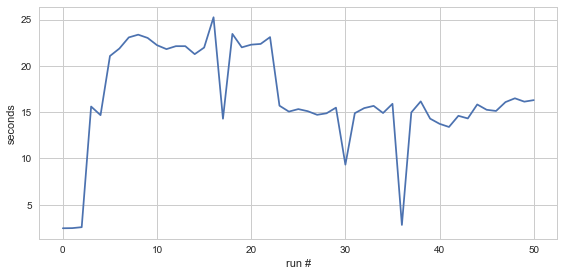

In [107]:
fig, axes = plt.subplots(figsize=(8,4))
runtime.duration.plot(ax=axes)
axes.set_ylabel('seconds'); axes.set_xlabel('run #')
fig.tight_layout()

# Runtime per record

In [108]:
def b(row):
    return row.duration / row.numProcessed
runtime['perRecord'] = runtime.apply(lambda x : b(x), axis=1)

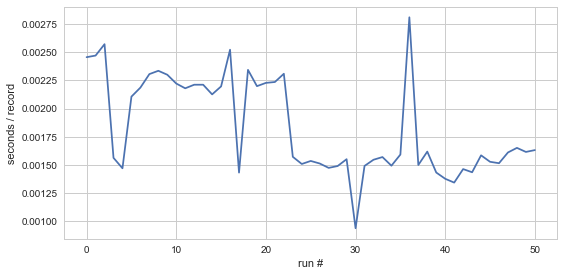

In [109]:
fig, axes = plt.subplots(figsize=(8,4))
runtime.perRecord.plot(ax=axes)
axes.set_ylabel('seconds / record'); axes.set_xlabel('run #')
fig.tight_layout()

In [118]:
all_words = runtime[ runtime.note == 'keeping stopwords']
no_stops = runtime[ runtime.note == 'filtering out stopwords']

In [123]:
totalTweets = 5798489
def estimate_total_time(runtimes, actual_items):
    timePer = runtimes.perRecord.mean()
    est = (actual_items * timePer) / 60 /60
    print("estimated %s hours" % est)
    return est

no stops 2.65959495765189 hrs 

In [124]:
estimate_total_time(no_stops, totalTweets)

estimated 2.2445344091019233 hours


2.2445344091019233

In [125]:
estimate_total_time(all_words, totalTweets)

estimated 2.5586026225565437 hours


2.5586026225565437

# Individual component run times for speed optimization

In [ ]:
%cd twitteranalysis
import environment
import pandas as pd
from pandas import DataFrame, Series
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

## Load and process the log data

In [ ]:

%cd twitteranalysis
import environment
import pandas as pd
from pandas import DataFrame, Series

# Load data
def load():
    d = pd.read_pickle(pickle)
    d.set_index('timestamps', inplace=True)
    print(len(d))
    return d

pickle = "%s/working-pickle" % environment.PROFILING_LOG_FOLDER_PATH

file_stems = ['client-send', 'client-enque', 'server-receive', 
              'server-save']
# def load(file_stems = file_stems):
series = []
columns = []
for f in file_stems:
    # make full file path
    path = "%s/%s.csv" % (environment.PROFILING_LOG_FOLDER_PATH, f)
    # read it in as a series
    s = pd.read_csv(path, squeeze=True)
    # NB, not converting to timestamp yet since easier to compare strings
    # s = s.apply(lambda x : pd.to_datetime(x))
    series.append(s)
    columns.append(f.replace('-', '_') )

d = [{ columns[i] : series[i]} for i in range(0, len(series))]

# create a unique list of timestamp strings
# these will serve as the index of the datafram
ts = pd.concat(series)
ts = set(ts.values)
print("%s unique timestamps" % len(ts))

# create the dataframe with the full index
# and named columns, but no data
data = DataFrame(index=ts, columns=columns)
data.reset_index(inplace=True)
# we have trouble with an upcoming apply step if the timestamps
# are the index or if the column is named index, so we rename it
data = data.rename({'index':'timestamps'}, axis=1)

# populate the dataframe
# This takes awhile.....
def ff(row, values, goodVal):
    if row.timestamps in values:
        return goodVal
    return 0

for i in range(0, len(columns)):
    name = columns[i]
    vs = series[i].values
    goodVal = i + 1
    data[name] = data.apply(lambda x : ff(x, vs, goodVal ), axis=1)

# Now that the comparison stuff is done,
# we can convert to actual datetimes
data.timestamps = data.timestamps.apply(lambda x: pd.to_datetime(x))

data.set_index('timestamps', inplace=True)
data.sort_index(inplace=True, axis=0)
data.reset_index(inplace=True)

# save the data to a file so we don't have to do the above
# every time
data.to_pickle(pickle)
print("Done")

## Plot timestamps 

In [ ]:
d = load()

In [ ]:
# consolidate at the seconds level
d = d.resample('s').mean()
len(d)

In [ ]:
fig, axes = plt.subplots(figsize=(8,5))
d.plot(kind='bar', ax=axes)
fig.tight_layout()

## Expected times

In [ ]:
# Load data
d = load()

In [ ]:
delta = d.index.max() - d.index.min()

In [128]:
round(3.4555543)

3

In [ ]:
c = delta.components
c.milliseconds /60

In [ ]:
# numberUsersProcessed = 100
numberUsersProcessed = 4352
actualUsers = 1328927
pctActual = numberUsersProcessed / actualUsers

In [ ]:
delta.milliseconds / 60

In [ ]:
seconds_per_user = delta / numberUsersProcessed
seconds_per_user

In [ ]:
est_seconds = actualUsers * seconds_per_user
est_min = est_seconds / 60
est_min

In [ ]:
est_hours = est_min / 60
est_hours

5/19 11.31
    - change: turned off integrity logging 
    - batch size of queue: 500
    - elapsed: 8 seconds
    - seconds/user: 0.0018
    - actual users 1328927
    - estimated minutes: 40.7
    - estimated hours: 0.67



5/17 4.51
    - change: all users now being saved correctly
    - batch size of queue: 500
    - elapsed: 49 seconds
    - seconds/user: 0.011
    - actual users 1328927
    - estimated minutes: 249.38
    - estimated hours: 4.16


5/16 3.21
    - change: changed get handler (queue flush) to coroutine
    - batch size of queue: 500
    - elapsed: 30 seconds
    - seconds/user: 0.0069
    - actual users 1328927
    - estimated minutes: 152.68
    - estimated hours: 2.54

5/15 8.08
    - change: changed server enque back to coroutine. Issue of the server not recording some recieved records remains fixed
    - batch size of queue: 500
    - elapsed: 30 seconds
    - seconds/user: 0.0069
    - actual users 1328927
    - estimated minutes: 152.68
    - estimated hours: 2.54


5/15 7.48
    - change: lock added to server side enque; changed from coroutine to async. this fixed the server not recording some recieved records
    - batch size of queue: 500
    - elapsed: 31 seconds
    - seconds/user: 0.0044
    - actual users 1328927
    - estimated minutes: 157.77
    - estimated hours: 2.63

5/15 6.27 
    - change: lock added back to sqlite writer
    - batch size of queue: 500
    - elapsed: 19 seconds
    - seconds/user: 0.0044
    - actual users 1328927
    - estimated minutes: 96.7
    - estimated hours: 1.61


5/15 10.37 
    - change: lock removed from sqlite writer; using single db
    - batch size of queue: 500
    - elapsed: 22 seconds
    - seconds/user: 0.005
    - actual users 1328927
    - estimated minutes: 111.97
    - estimated hours: 1.87

5/15 10.37 
    - change: lock added to sqlite writer
    - batch size of queue: 500
    - elapsed: 19 seconds
    - seconds/user: 0.0044
    - actual users 1328927
    - estimated minutes: 96.7
    - estimated hours: 1.61

5/15 10.37
    - batch size of queue: 500
    - elapsed: 20 seconds
    - seconds/user: 
    - actual users 1328927
    - estimated minutes: 101.787
    - estimated hours: 1.696

5/15 10.22
    - batch size of queue: 100
    - elapsed: 22 seconds
    - seconds/user: 0.0051
    - actual users 1328927
    - estimated minutes: 111.965
    - estimated hours: 1.866


5/14 7.00
    - batch size of queue: 10
    - elapsed: 34 seconds
    - seconds/user: 0.0078
    - actual users 1328927
    - estimated minutes: 173.037
    - estimated hours: 2.884


5/14 5.30
    - batch size of queue: 10
    - elapsed: 62 seconds
    - seconds/user: 0.014246
    - actual users 1328927
    - estimated minutes: 315.54
    - estimated hours: 5.26
    


In [ ]:
client_send = client_send.apply(lambda x : pd.to_datetime(x))

In [ ]:
client_enque = client_enque.apply(lambda x : pd.to_datetime(x))

In [ ]:
len(client_enque)

In [ ]:
client_enque[:4]

In [ ]:
client_send[:4]

In [ ]:
server_receive.columns[0]

In [ ]:
server_receive

In [ ]:
from profiling.OptimizingTools import log_start_stop

In [ ]:
import time

loc = '%s/test-log.csv' % environment.LOG_FOLDER_PATH

@log_start_stop(loc)
def test():
    print('j')
    time.sleep(5)
    print('k')



In [ ]:
test()

In [ ]:
# numberUsersProcessed = 100
numberUsersProcessed = 4352
actualUsers = 1328927
pctActual = numberUsersProcessed / actualUsers

In [ ]:

BASE = os.getenv("HOME")
# todo restore environment
# from TwitterDataAnalysis.environment import *

# Logging
LOG_FOLDER_PATH = "%s/Desktop/TwitterDataAnalysisLogs" % BASE

query_log = '%s/query_log.csv' % LOG_FOLDER_PATH
query_time_log = '%s/query_time_log.csv' % LOG_FOLDER_PATH


request_log = '%s/request_log.csv' % LOG_FOLDER_PATH
request_time_log = '%s/request_time_log.csv' % LOG_FOLDER_PATH


def r(x):
    if x[0] == '0':
        x = '2%s' % x 
    return pd.to_datetime(x)

queries = pd.read_csv(query_log,  header=None, names=['runtime'])
query_timestamps = pd.read_csv(query_time_log,  header=None, names=['runTimestamp'])
query_timestamps = query_timestamps.apply(lambda x: r(x.runTimestamp), axis=1)
queries.dropna(inplace=True)

requests = pd.read_csv(request_log,  header=None, names=['runtime'])
request_timestamps = pd.read_csv(request_time_log,  header=None, names=['runTimestamp'])
request_timestamps = request_timestamps.apply(lambda x: r(x.runTimestamp), axis=1)
requests.dropna(inplace=True)

# DB query log

In [ ]:
totalSeconds = queries.runtime.sum()
meanRuntime = queries.runtime.mean()
totalRecords = len(queries)
print("Made %s queries in %s seconds (%s minutes). " %(totalRecords, totalSeconds, totalSeconds/60))

In [ ]:
queriesPerUser = len(queries) / numberUsersProcessed 
print("%s queries per user" % queriesPerUser)
estQueryTime = queriesPerUser * meanRuntime * actualUsers
estQueryTime

In [ ]:
elapsedTime = query_timestamps.max() -query_timestamps.min()
elapsedTime

In [ ]:
queries.describe()

In [ ]:
sns.boxplot(queries)

In [ ]:
queries[:4]

In [ ]:
totalEstTime = queries.index.max() - queries.index.min()
actualUsers * (totalEstTime / numberUsersProcessed)

In [ ]:
queries.plot()

In [ ]:
query_timestamps.T.plot()

In [ ]:
d = queries[:50]
d = d.reset_index()

In [ ]:
d.runTimestamp[0]

# Request time logs

In [ ]:
totalSeconds = requests.runtime.sum()
meanRuntime = requests.runtime.mean()
totalRecords = len(requests)
print("Handled %s requests in %s seconds (%s minutes). " %(totalRecords, totalSeconds, totalSeconds/60))

In [ ]:
requests.describe()

In [ ]:
avgRequestsPerUser = totalRecords / numberUsersProcessed
print("Average requests per user %s" % avgRequestsPerUser)

expectedRequests = totalUsers * avgRequestsPerUser
print("Estimated number of requests required: %s" % round(expectedRequests))
expRun = expectedRequests * meanRuntime 
print("Expected runtime: %s hours" % (expRun / 60))

In [ ]:
requests.plot()

In [ ]:
request_timestamps.T.plot()

In [ ]:
elapsedTime = request_timestamps.max() - request_timestamps.min()
elapsedTime

In [ ]:
totalTime = requests.runtime.sum()
totalTime

It took 1 minute to process 4352 users, how many minutes to process all?

In [ ]:
(actualUsers / numberUsersProcessed) / 60

In [ ]:
#set index
def ffff(row):
    return Period(row.runtime, freq="D")
#     return Period(row.purchaseDate, freq="%sD" % row.days)

mjPurchases['standardDate'] = mjPurchases.apply(lambda x: ffff(x), axis=1)


In [ ]:
d = []
for idx, row in request_timestamps.iteritems():
    d.append(row - request_timestamps.iloc[idx -1])
d = pd.Series(d)

In [ ]:
d.plot()

# Storage requirements estimation

masterdb bytes 
    - without stopwords: 2,985,984
    - with stopwords: 4,141,056

In [77]:
masterdb_bytes = 4141056
processed = 10000
actualItems = 5798489

In [78]:
def convert(num_bytes):
    to_gb = 0.000000001
    to_mb = 0.000001
    return round(num_bytes * to_mb)


def estimate_needed_bytes(masterdb_bytes, processed, actual_items):
    spacePerItem = masterdb_bytes / processed
    neededBytes = actual_items * spacePerItem
    return neededBytes

assert(estimate_needed_bytes(10, 10, 13) == 13)

In [79]:
bts = estimate_needed_bytes(masterdb_bytes, processed, actualItems)
print("%s MB required" % convert(bts))

2401 MB required


Estimated requirements 

    All
        5.98 GB
    
    no stopwords
   
        2.4 GB

In [ ]:
# 504,459,894 
# ~ 504 MB

# Benchmark tweet text processing tools

In [ ]:
%cd twitteranalysis

%run -i profiling/optimizing_string_processor.py

# Display results of benchmark runs

## String processing worker with different datastructures

In [ ]:


NUMTWEETS = 1181

def a(row):
    #correct experiment which iterated over the string
    if len(row.dataStructure) == 1:
        row.dataStructure = 'tuple'
        
    if row.tweetTime > 1 or row.numTweets > NUMTWEETS:
        row.tweetTime = row.totalTime / NUMTWEETS
    return row



#load from file
data = pd.read_csv("%s/tests/benchmarks/StringProcessingWorker.csv" % TEXT_TOOLS_PATH)
data.set_index(['id'], inplace=True)
#fix incorrectly calculated tweet times
data = data.apply(lambda x: a(x), axis=1)
#get rid of outliers from pycharm indexing
data = data[data.totalTime < 80]
data.drop(['module', 'note', 'timestamp'], axis=1, inplace=True)
len(data)

In [ ]:
fig, ax = plt.subplots(2)
# sns.boxplot(data=data[['totalTime', 'tweetTime']], orient='h', ax=ax[0])
sns.boxplot(data=data.totalTime, orient='h', ax=ax[0])
sns.boxplot(data=data.tweetTime, orient='h', ax=ax[1])
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(2, figsize=(12,6))
sns.boxplot(x="numThreads", y="totalTime", hue="dataStructure", data=data, ax=ax[0])
sns.boxplot(x="numThreads", y="tweetTime", hue="dataStructure", data=data, ax=ax[1])

In [ ]:

import matplotlib.ticker as ticker
# sns.set_style( {'xtick.major.size': 5.0})
g = sns.violinplot(x="numThreads", y="tweetTime", hue="dataStructure", data=data)
# g.set_xticklabels([i for i in range(0, 50, 5)])
# g.set(xticklabels=[i for i in range(0, 50, 5)])
# g.xaxis.set_major_locator(ticker.MultipleLocator(5))
# f = plt.gcf().get_axes()[0]
# f.set_xticks(5)

In [ ]:
fig, ax = plt.subplots(2)
sns.distplot(data.totalTime, kde=True, rug=True, ax=ax[0])
sns.distplot(data.tweetTime, kde=True, rug=True, ax=ax[1])
fig.tight_layout()

In [ ]:
import sys
sys.byteorder

In [ ]:
sns.factorplot(x="numThreads", y="totalTime", hue="dataStructure", data=data) #, kind="swarm") #, ax=axes[0])
fig = plt.gcf()
fig.set_size_inches(12,4)
fig.tight_layout()
# fig.get_axes()[0].set_ylim(0.025,0.04)

In [ ]:
sns.factorplot(x="numThreads", y="tweetTime", hue="dataStructure", data=data) #,ax=axes[1]);
fig = plt.gcf()
fig.set_size_inches(12,4)
fig.get_axes()[0].set_ylim(0.028,0.032)
fig.tight_layout()